**A few words about SOLAR FLARES...**
Solar flares are one of the most energetic events originating from the Sun and causing space weather disturbances. In a typical solar flare, the energy realesed can reach 10^32 ergs within a few seconds. Magnetic field distributions in sunpots or active regions determine the likelihood of flares. In an 11-year solar activity cycle, there can be 4000 sunspots, with a maximum 10% flaring. Can we predict which one will flare using machine learning approach?
[The research paper](https://iopscience.iop.org/article/10.3847/1538-4357/ac7955#apjac7955s3)

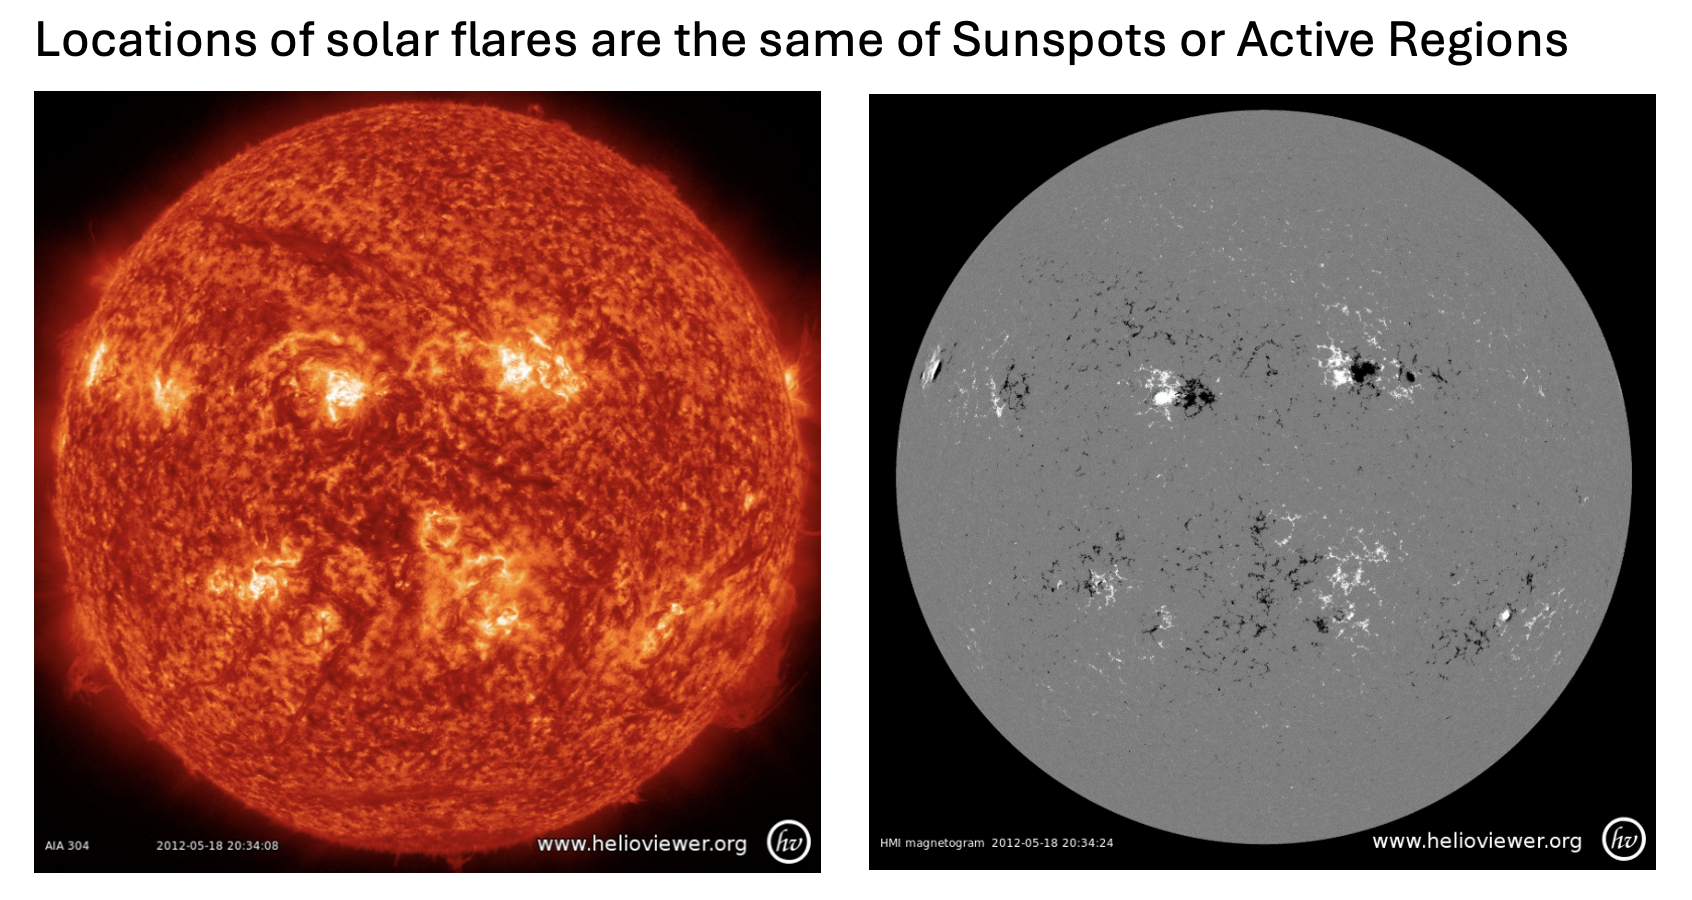

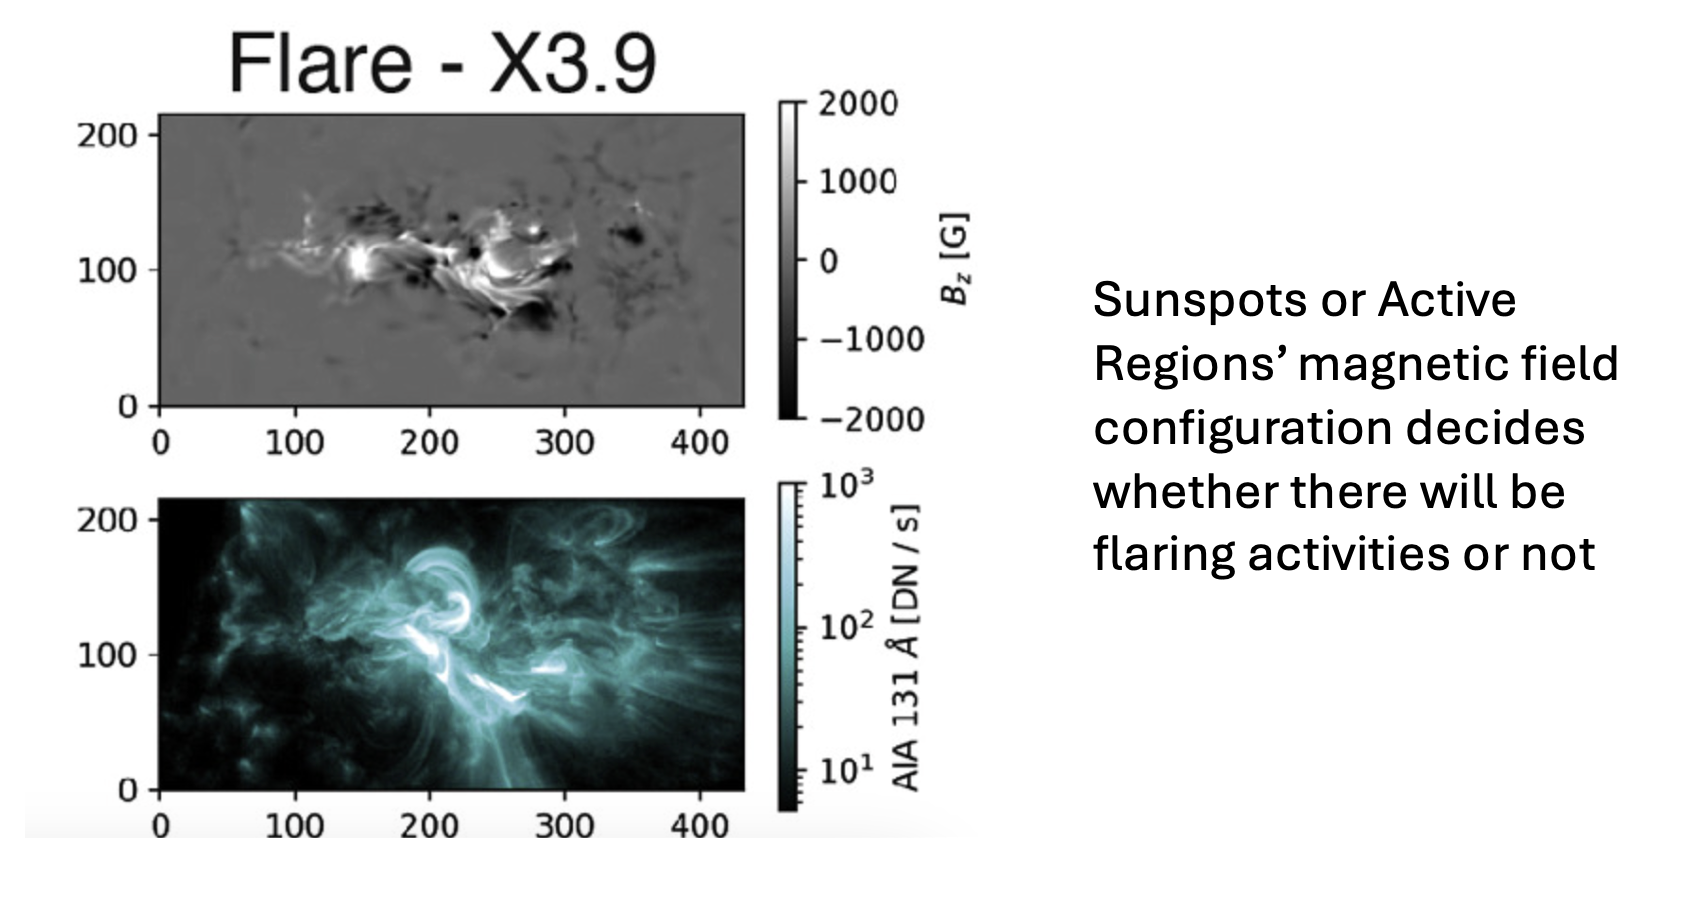

Let's look at the data now!
We have is 14 different parameters calculated based on the observed magnetic field distribution of approximately 4000 sunspots. All these parameters depend on the three vector components (Bx, By, Bz) of the sunspot magnetic fields.

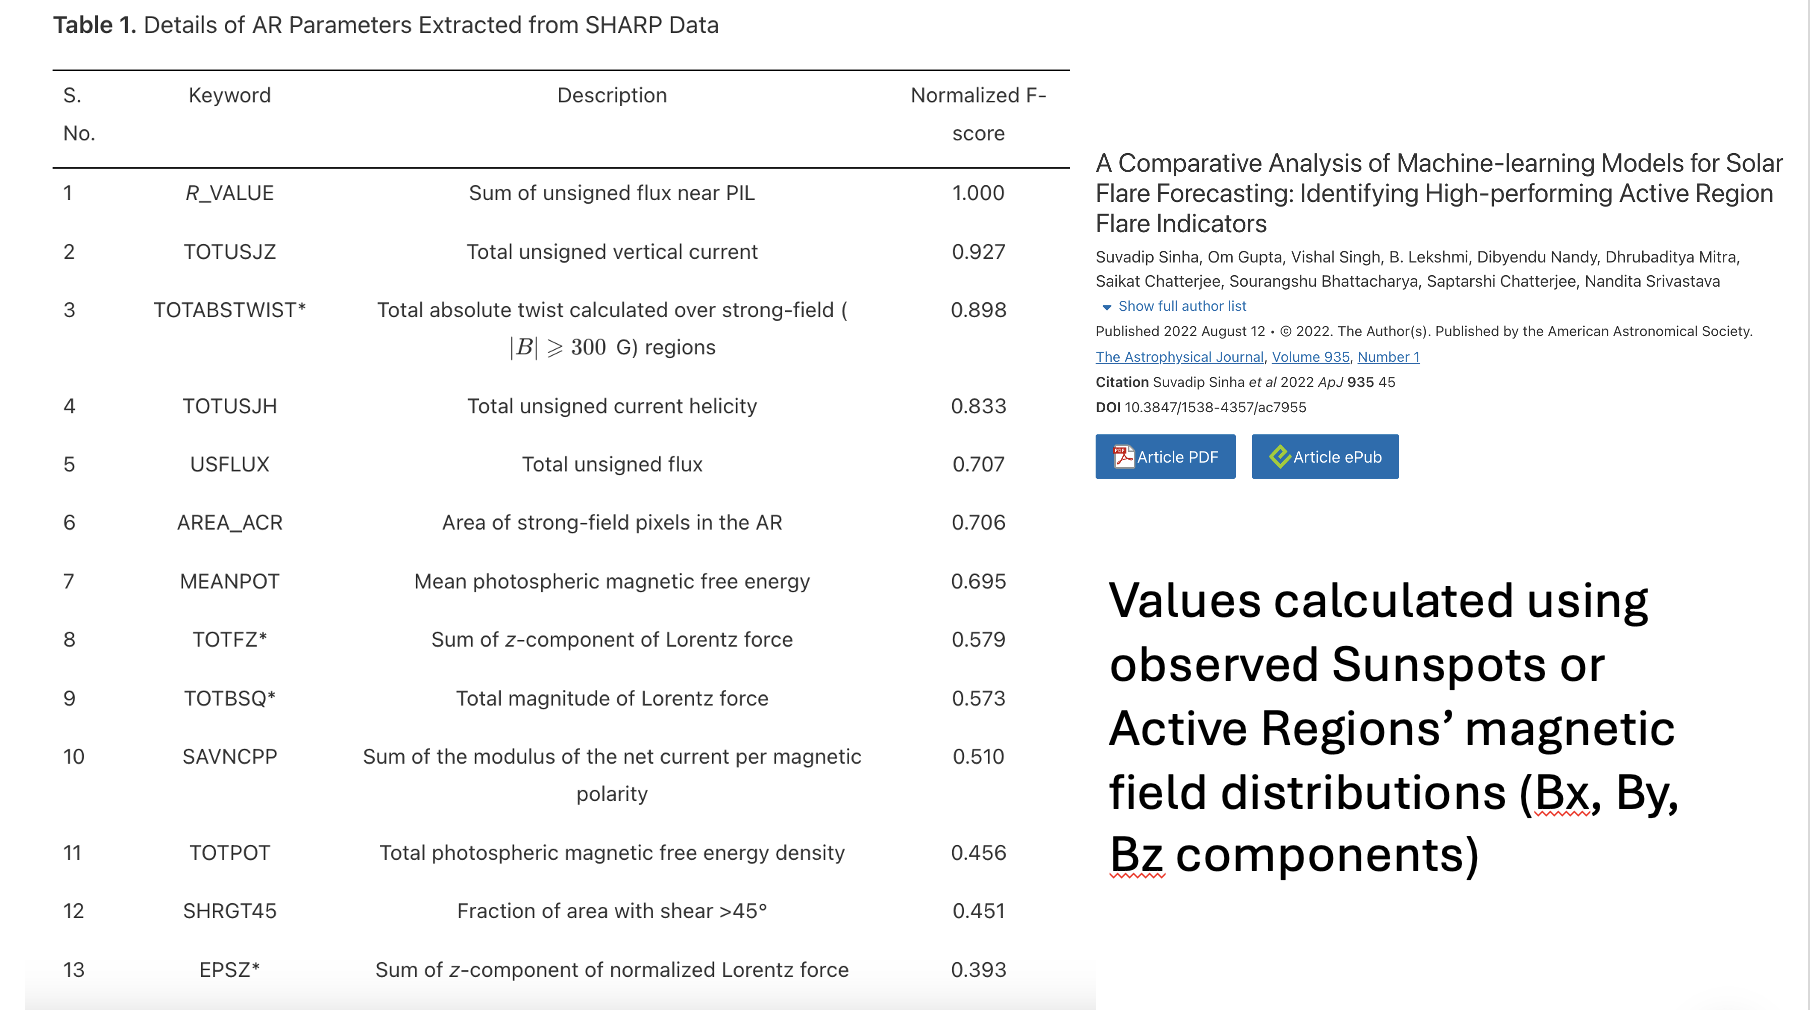

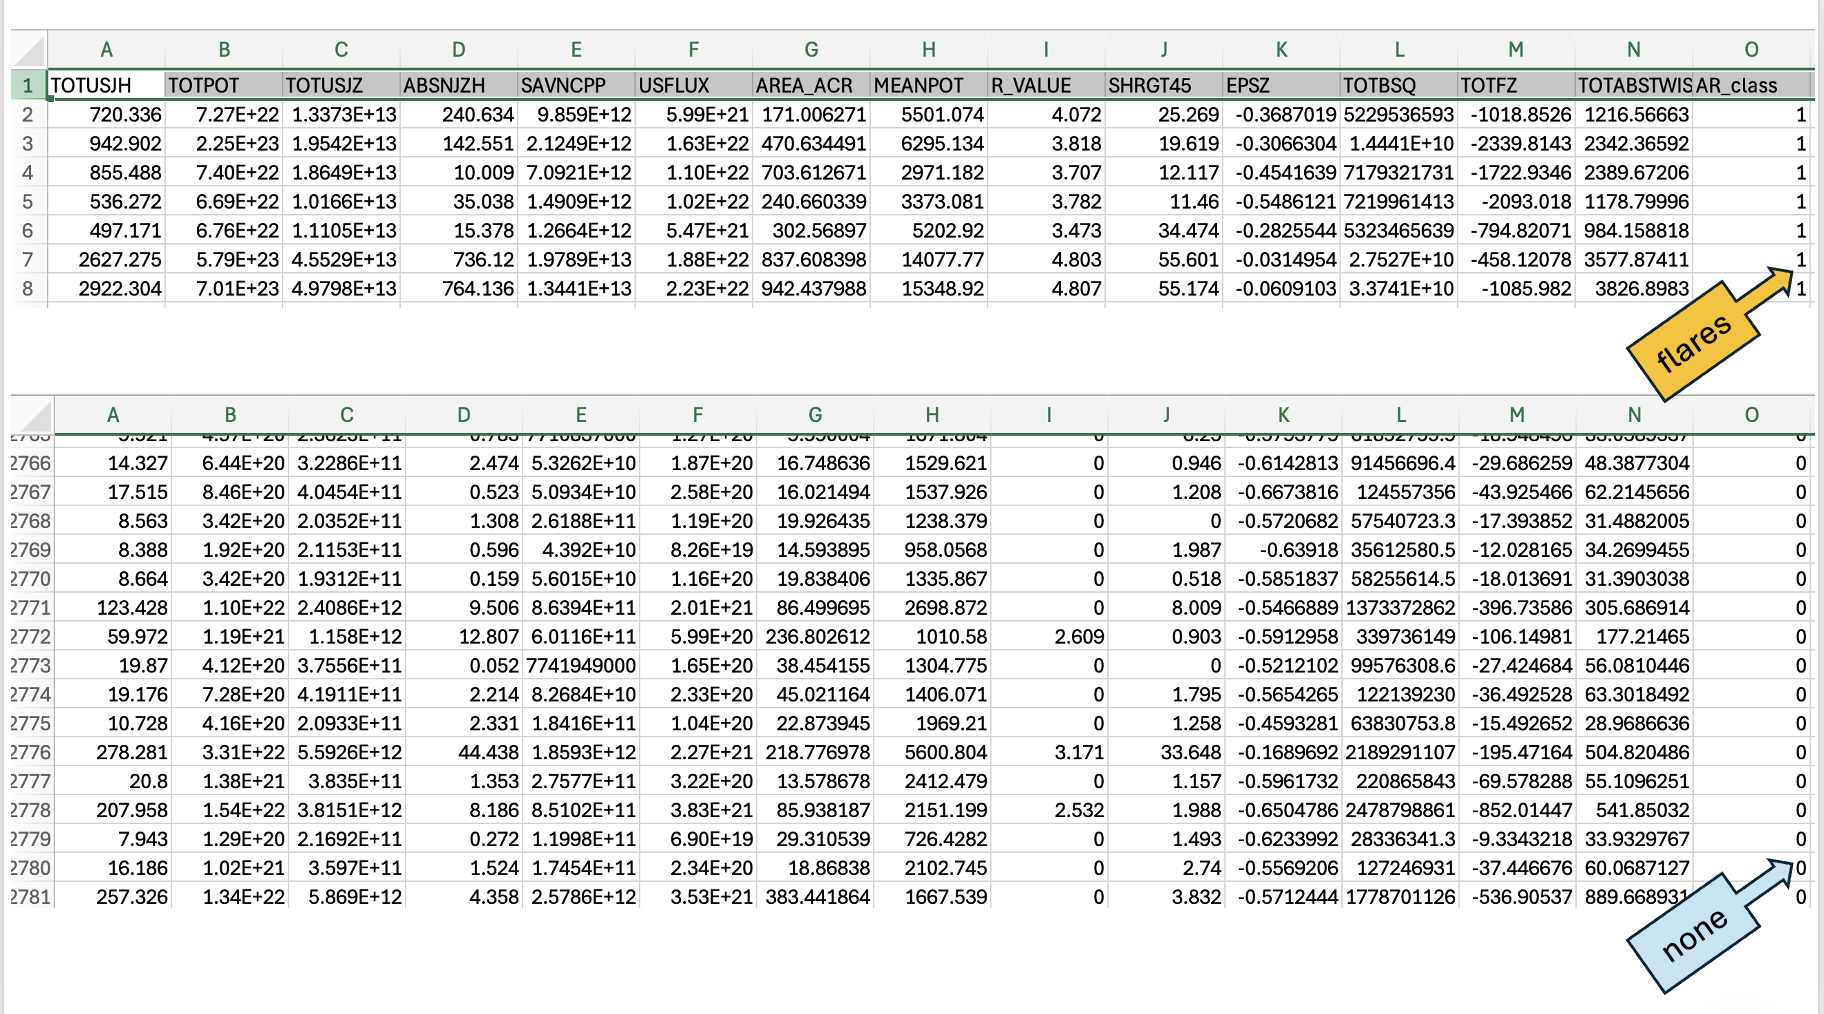

Let's now apply 4 different machine learning techniques (supervised) to test which one performs the best in flare prediction

In [24]:
# importing python packages to execute the programing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

Upload the data file locally: "active_region_dataset.xlsx"

In [25]:
# loading the data file
cols = ["TOTUSJH", "TOTPOT", "TOTUSJZ", "ABSNJZH", "SAVNCPP", "USFLUX", "AREA_ACR", "MEANPOT", "R_VALUE", "SHRGT45", "EPSZ", "TOTBSQ", "TOTFZ", "TOTABSTWIST", "AR_class"]
df = pd.read_csv("/content/active_region_dataset.csv", names=cols, skiprows=1)
print(df.head())

   TOTUSJH        TOTPOT       TOTUSJZ  ABSNJZH       SAVNCPP        USFLUX  \
0  720.336  7.265489e+22  1.337285e+13  240.634  9.859024e+12  5.987544e+21   
1  942.902  2.245220e+23  1.954248e+13  142.551  2.124900e+12  1.628014e+22   
2  855.488  7.395334e+22  1.864853e+13   10.009  7.092123e+12  1.104408e+22   
3  536.272  6.688043e+22  1.016615e+13   35.038  1.490940e+12  1.017101e+22   
4  497.171  6.762531e+22  1.110523e+13   15.378  1.266448e+12  5.466512e+21   

     AREA_ACR   MEANPOT  R_VALUE  SHRGT45      EPSZ        TOTBSQ  \
0  171.006271  5501.074    4.072   25.269 -0.368702  5.229537e+09   
1  470.634491  6295.134    3.818   19.619 -0.306630  1.444087e+10   
2  703.612671  2971.182    3.707   12.117 -0.454164  7.179322e+09   
3  240.660339  3373.081    3.782   11.460 -0.548612  7.219961e+09   
4  302.568970  5202.920    3.473   34.474 -0.282554  5.323466e+09   

         TOTFZ  TOTABSTWIST  AR_class  
0 -1018.852566  1216.566630       1.0  
1 -2339.814306  2342.365915   

In [26]:
# how many classes are there? TWO, 1 (flaring), 0(non-flaring)
print('types of classes: ', df["AR_class"].unique())

types of classes:  [1. 0.]


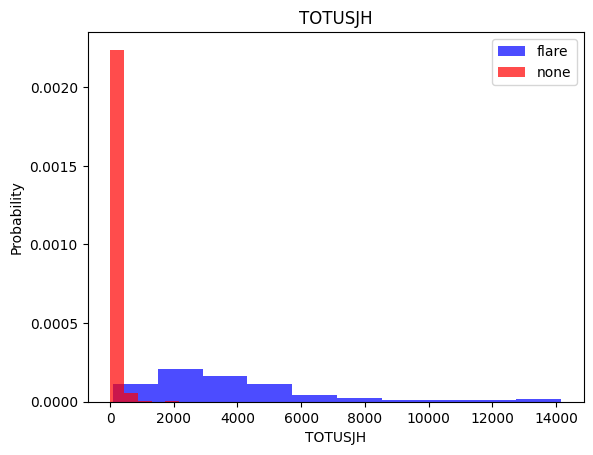

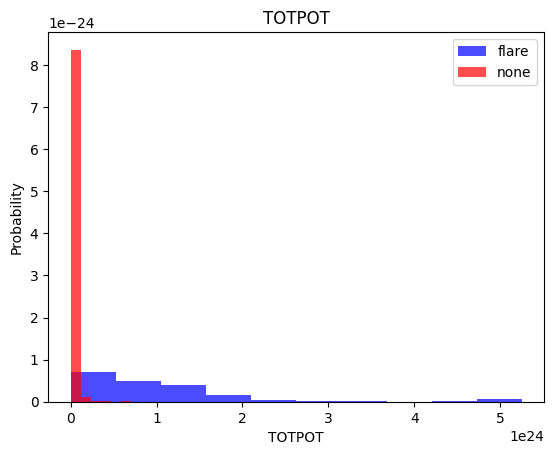

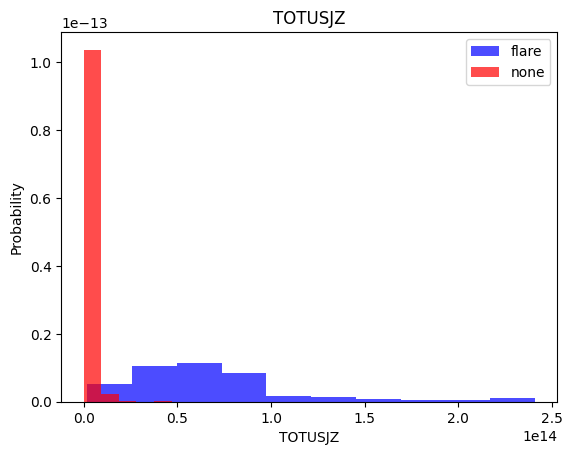

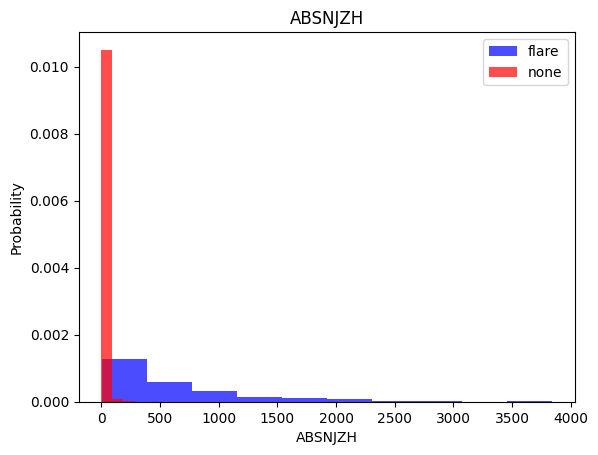

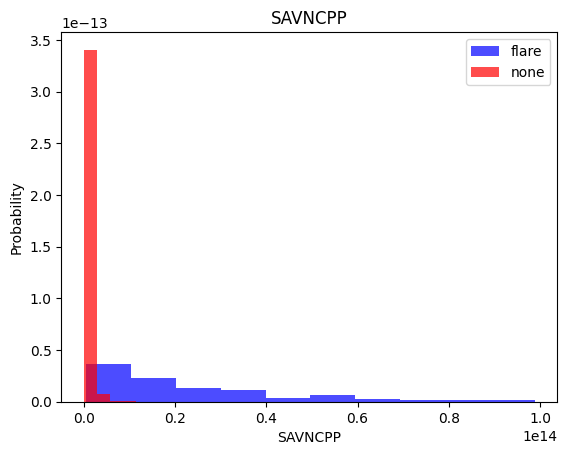

In [27]:
# Let's look at the histograms of different parameters for flaring vs non-flaring ARs
for label in cols[:-10]:
  plt.hist(df[df["AR_class"]==1.0][label], color='blue', label='flare', alpha=0.7, density=True)
  plt.hist(df[df["AR_class"]==0.0][label], color='red', label='none', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [28]:
# Train, validation, test datasets (60:20:20)
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
# check how even is the dataset
print('number of flares in train data: ', len(train[train["AR_class"]==1]))
print('number of non-flares in train data: ', len(train[train["AR_class"]==0]))


number of flares in train data:  307
number of non-flares in train data:  2009


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [29]:
# increasing or oversampling the dataset to remove any bias
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

# check how even is the dataset after oversampling
print('number of flares in train data post-oversampling: ', sum(y_train == 1))
print('number of non-flares in train data post-oversampling: ', sum(y_train == 0))


number of flares in train data post-oversampling:  2009
number of non-flares in train data post-oversampling:  2009


**Preparation of the dataset is done! Now we apply the ML codes!**

In [30]:
# ML technique: k-nearest-neighbour

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print('kNN: ', classification_report(y_test, y_pred))
#print(type(classification_report(y_test, y_pred)))

with open("kNN.txt", "w") as text_file:
    print(classification_report(y_test, y_pred), file=text_file)



kNN:                precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       675
         1.0       0.84      0.97      0.90        98

    accuracy                           0.97       773
   macro avg       0.92      0.97      0.94       773
weighted avg       0.98      0.97      0.97       773



In [31]:
# ML technique: Naive-Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print('naive_bayes: ',classification_report(y_test, y_pred))
with open("naive-bayes.txt", "w") as text_file:
    print(classification_report(y_test, y_pred), file=text_file)



naive_bayes:                precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       675
         1.0       0.78      0.98      0.87        98

    accuracy                           0.96       773
   macro avg       0.89      0.97      0.92       773
weighted avg       0.97      0.96      0.96       773



In [32]:
# ML technique: Log Regression

from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

y_pred = lg_model.predict(X_test)
print('log-regression: ', classification_report(y_test, y_pred))
with open("log-regression.txt", "w") as text_file:
    print(classification_report(y_test, y_pred), file=text_file)



log-regression:                precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       675
         1.0       0.87      0.98      0.92        98

    accuracy                           0.98       773
   macro avg       0.93      0.98      0.96       773
weighted avg       0.98      0.98      0.98       773



In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# ML technique: Support Vector Machine (SVM)

from sklearn.svm import SVC
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print('SVM: ', classification_report(y_test, y_pred))
with open("SVM.txt", "w") as text_file:
    print(classification_report(y_test, y_pred), file=text_file)



SVM:                precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       675
         1.0       0.88      0.98      0.93        98

    accuracy                           0.98       773
   macro avg       0.94      0.98      0.96       773
weighted avg       0.98      0.98      0.98       773

